In [9]:
import sys
sys.path.append("../scripts")
sys.path.append("../datasets")


In [10]:
from cargar_dataset import cargar_dataset
from config_datasets import config_datasets
from evaluacion import evaluar_sampler_holdout
from custom_samplers import PCSMOTEWrapper

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    f1_score, balanced_accuracy_score,
    matthews_corrcoef, cohen_kappa_score
)
from sklearn.preprocessing import LabelEncoder
from pc_smote import PCSMOTE

In [11]:
def evaluar_pcsmote_grid_search(nombre_dataset, config, percentiles_densidad, percentiles_riesgo, criterios_pureza, modelo_clasificador, nombre_modelo):
    print(f"📂 Cargando dataset: {nombre_dataset}")
    X, y, _ = cargar_dataset(
        path=config["path"],
        clase_minoria=config.get("clase_minoria"),
        col_features=config.get("col_features"),
        col_target=config.get("col_target"),
        sep=config.get("sep", ","),
        header=config.get("header", None),
        binarizar=False,
        tipo=config.get("tipo", "tabular")
    )

    if y.dtype == object or isinstance(y[0], str):
        y = LabelEncoder().fit_transform(y)

    if config.get("tipo") == "imagen":
        X = X.reshape((X.shape[0], -1)).astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    n_components = min(X_train.shape[1], 100)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    resultados = []

    for pdens in percentiles_densidad:
        for priesgo in percentiles_riesgo:
            for criterio in criterios_pureza:
                print(f"🧪 {nombre_modelo} | {nombre_dataset} | Densidad: {pdens} | Riesgo: {priesgo} | Pureza: {criterio}")

                sampler = PCSMOTE(
                    random_state=42,
                    percentil_densidad=pdens,
                    percentil_dist=priesgo,
                    criterio_pureza=criterio,
                    modo_espacial='3d'
                )

                try:
                    if hasattr(sampler, "fit_resample_multiclass"):
                        X_res, y_res = sampler.fit_resample_multiclass(X_train_pca, y_train)
                    else:
                        X_res, y_res = sampler.fit_resample(X_train_pca, y_train)

                    modelo_clasificador.fit(X_res, y_res)
                    y_pred = modelo_clasificador.predict(X_test_pca)

                    resultados.append({
                        'dataset': nombre_dataset,
                        'modelo': nombre_modelo,
                        'densidad': pdens,
                        'riesgo': priesgo,
                        'pureza': criterio,
                        'f1_score': f1_score(y_test, y_pred, average='weighted'),
                        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
                        'mcc': matthews_corrcoef(y_test, y_pred),
                        'cohen_kappa': cohen_kappa_score(y_test, y_pred)
                    })

                except Exception as e:
                    print(f"⚠️ Error: {e}")
                    resultados.append({
                        'dataset': nombre_dataset,
                        'modelo': nombre_modelo,
                        'densidad': pdens,
                        'riesgo': priesgo,
                        'pureza': criterio,
                        'f1_score': None,
                        'balanced_accuracy': None,
                        'mcc': None,
                        'cohen_kappa': None,
                        'error': str(e)
                    })

    df = pd.DataFrame(resultados)
    df.to_csv(f"../resultados/pcsmote_grid_{nombre_dataset}_{nombre_modelo}.csv", index=False)
    print(f"📁 Resultados guardados en: ../resultados/pcsmote_grid_{nombre_dataset}_{nombre_modelo}.csv")


In [12]:
def evaluar_otra_tecnica_grid(nombre_dataset, config, tecnica, modelo_clasificador, nombre_modelo, nombre_tec):
    print(f"📂 Cargando dataset: {nombre_dataset}")
    X, y, _ = cargar_dataset(
        path=config["path"],
        clase_minoria=config.get("clase_minoria"),
        col_features=config.get("col_features"),
        col_target=config.get("col_target"),
        sep=config.get("sep", ","),
        header=config.get("header", None),
        binarizar=False,
        tipo=config.get("tipo", "tabular")
    )

    if y.dtype == object or isinstance(y[0], str):
        y = LabelEncoder().fit_transform(y)

    if config.get("tipo") == "imagen":
        X = X.reshape((X.shape[0], -1)).astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    n_components = min(X_train.shape[1], 100)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    if tecnica is not None:
        try:
            X_res, y_res = tecnica.fit_resample(X_train_pca, y_train)
        except Exception as e:
            print(f"⚠️ Error al aplicar técnica {nombre_tec}: {e}")
            return
    else:
        X_res, y_res = X_train_pca, y_train

    try:
        modelo_clasificador.fit(X_res, y_res)
        y_pred = modelo_clasificador.predict(X_test_pca)

        df = pd.DataFrame([{
            'dataset': nombre_dataset,
            'modelo': nombre_modelo,
            'tecnica': nombre_tec,
            'f1_score': f1_score(y_test, y_pred, average='weighted'),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'cohen_kappa': cohen_kappa_score(y_test, y_pred)
        }])

        df.to_csv(f"../resultados/{nombre_tec}_grid_{nombre_dataset}_{nombre_modelo}.csv", index=False)
        print(f"📁 Resultados guardados en: ../resultados/{nombre_tec}_grid_{nombre_dataset}_{nombre_modelo}.csv")

    except Exception as e:
        print(f"⚠️ Error al entrenar/evaluar: {e}")


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from config_datasets import config_datasets
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

tecnicas_sobremuestreo = {
    "base": None,
    "pcsmote": PCSMOTE(
        random_state=42,
        percentil_densidad=50,  # serán reemplazados dinámicamente en el grid
        percentil_dist=50,
        criterio_pureza='entropia',
        modo_espacial='3d',
        verbose=False
    ),
    "smote": SMOTE(random_state=42),
    "adasyn": ADASYN(random_state=42),
    "borderline": BorderlineSMOTE(random_state=42)
}

modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(random_state=42)
    # "XGBoost": XGBClassifier(...)  ← agregalo si tenés instalado `xgboost`
}

percentiles_densidad = [25, 50, 75]
percentiles_riesgo = [25, 50, 75]
criterios_pureza = ["entropia", "proporcion"]

for nombre_dataset, config in config_datasets.items():
    if nombre_dataset == "eurosat":
        continue

    for nombre_modelo, modelo in modelos.items():
        for nombre_tec, tecnica in tecnicas_sobremuestreo.items():
            print(f"\n=== Ejecutando grid para {nombre_dataset} | modelo: {nombre_modelo} | técnica: {nombre_tec} ===")

            if nombre_tec == "pcsmote":
                evaluar_pcsmote_grid_search(
                    nombre_dataset, config,
                    percentiles_densidad, percentiles_riesgo,
                    criterios_pureza, modelo, nombre_modelo
                )
            else:
                evaluar_otra_tecnica_grid(
                    nombre_dataset, config, tecnica,
                    modelo, nombre_modelo, nombre_tec
                )


=== Ejecutando grid para ecoli | modelo: RandomForest | técnica: base ===
📂 Cargando dataset: ecoli
📁 Resultados guardados en: ../resultados/base_grid_ecoli_RandomForest.csv

=== Ejecutando grid para ecoli | modelo: RandomForest | técnica: pcsmote ===
📂 Cargando dataset: ecoli
🧪 RandomForest | ecoli | Densidad: 25 | Riesgo: 25 | Pureza: entropia
📌 Total muestras minoritarias: 61
📌 Total muestras mayoritarias: 207
📌 Total muestras minoritarias: 2
📌 Total muestras mayoritarias: 266
⚠️ Muy pocas muestras minoritarias (2). Se requieren al menos 6. Devolviendo dataset original.
📌 Total muestras minoritarias: 2
📌 Total muestras mayoritarias: 266
⚠️ Muy pocas muestras minoritarias (2). Se requieren al menos 6. Devolviendo dataset original.
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 240
📌 Total muestras minoritarias: 16
📌 Total muestras mayoritarias: 252
📌 Total muestras minoritarias: 4
📌 Total muestras mayoritarias: 264
⚠️ Muy pocas muestras minoritarias (4). Se requier

c:\Users\FamiliaNatelloMedina\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🧪 LogisticRegression | heart | Densidad: 25 | Riesgo: 25 | Pureza: proporcion
📌 Total muestras minoritarias: 43
📌 Total muestras mayoritarias: 194
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
⚠️ Muy pocas muestras luego del filtrado (0). Se requieren al menos 6. Devolviendo dataset original.
📌 Total muestras minoritarias: 10
📌 Total muestras mayoritarias: 227
⚠️ Muy pocas muestras luego del filtrado (0). Se requieren al menos 6. Devolviendo dataset original.
🧪 LogisticRegression | heart | Densidad: 25 | Riesgo: 50 | Pureza: entropia
📌 Total muestras minoritarias: 43
📌 Total muestras mayoritarias: 194
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 10
📌 Total muestras mayoritarias: 227
🧪 LogisticRegression | heart | Densidad: 25 | Riesgo: 50 | Pureza: proporcion
📌 Total muestr

c:\Users\FamiliaNatelloMedina\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🧪 LogisticRegression | heart | Densidad: 50 | Riesgo: 25 | Pureza: proporcion
📌 Total muestras minoritarias: 43
📌 Total muestras mayoritarias: 194
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
⚠️ Muy pocas muestras luego del filtrado (0). Se requieren al menos 6. Devolviendo dataset original.
📌 Total muestras minoritarias: 10
📌 Total muestras mayoritarias: 227
⚠️ Muy pocas muestras luego del filtrado (0). Se requieren al menos 6. Devolviendo dataset original.
🧪 LogisticRegression | heart | Densidad: 50 | Riesgo: 50 | Pureza: entropia
📌 Total muestras minoritarias: 43
📌 Total muestras mayoritarias: 194
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 10
📌 Total muestras mayoritarias: 227
🧪 LogisticRegression | heart | Densidad: 50 | Riesgo: 50 | Pureza: proporcion
📌 Total muestr

c:\Users\FamiliaNatelloMedina\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🧪 LogisticRegression | heart | Densidad: 75 | Riesgo: 25 | Pureza: proporcion
📌 Total muestras minoritarias: 43
📌 Total muestras mayoritarias: 194
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
⚠️ Muy pocas muestras luego del filtrado (0). Se requieren al menos 6. Devolviendo dataset original.
📌 Total muestras minoritarias: 10
📌 Total muestras mayoritarias: 227
⚠️ Muy pocas muestras luego del filtrado (0). Se requieren al menos 6. Devolviendo dataset original.
🧪 LogisticRegression | heart | Densidad: 75 | Riesgo: 50 | Pureza: entropia
📌 Total muestras minoritarias: 43
📌 Total muestras mayoritarias: 194
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 28
📌 Total muestras mayoritarias: 209
📌 Total muestras minoritarias: 10
📌 Total muestras mayoritarias: 227
🧪 LogisticRegression | heart | Densidad: 75 | Riesgo: 50 | Pureza: proporcion
📌 Total muestr

In [20]:
import pandas as pd
import os
import glob

datasets = ['ecoli', 'wdbc', 'glass', 'heart']
tecnicas = ['base', 'smote', 'adasyn', 'borderline', 'pcsmote']
modelos = ['RandomForest', 'LogisticRegression', 'SVM']

resumen = []

for dataset in datasets:
    for tecnica in tecnicas:
        archivos = glob.glob(f"../resultados/{tecnica}_grid_{dataset}_*.csv")
        if not archivos:
            print(f"⚠️ No hay resultados para {dataset} con técnica {tecnica}")
            continue

        mejores_filas = []

        for archivo in archivos:
            try:
                df = pd.read_csv(archivo)
                df_valid = df.dropna(subset=["f1_score"])
                if df_valid.empty:
                    continue

                fila = df_valid.sort_values(by="f1_score", ascending=False).iloc[0].copy()
                fila['dataset'] = dataset
                fila['tecnica'] = tecnica

                nombre_archivo = os.path.basename(archivo)
                modelo_detectado = next((m for m in modelos if m in nombre_archivo), "desconocido")
                fila['modelo'] = modelo_detectado

                mejores_filas.append(fila)

            except Exception as e:
                print(f"⚠️ Error procesando {archivo}: {e}")


        # Guardar el mejor resultado por técnica
        if mejores_filas:
            mejor = pd.DataFrame(mejores_filas).sort_values(by="f1_score", ascending=False).iloc[0]
            resumen.append(mejor)

# Crear DataFrame final
resumen_df = pd.DataFrame(resumen)

# Reordenar columnas según disponibilidad
cols = ['dataset', 'tecnica', 'modelo', 'f1_score']
for col in ['balanced_accuracy', 'mcc', 'cohen_kappa', 'densidad', 'riesgo', 'pureza']:
    if col in resumen_df.columns:
        cols.append(col)

resumen_df = resumen_df[cols]
resumen_df.to_csv("../resultados/resumen_mejores_por_tecnica.csv", index=False)
print("✅ Resumen guardado en ../resultados/resumen_mejores_por_tecnica.csv")


⚠️ No hay resultados para ecoli con técnica smote
⚠️ No hay resultados para ecoli con técnica adasyn
⚠️ No hay resultados para ecoli con técnica borderline
⚠️ No hay resultados para glass con técnica adasyn
✅ Resumen guardado en ../resultados/resumen_mejores_por_tecnica.csv


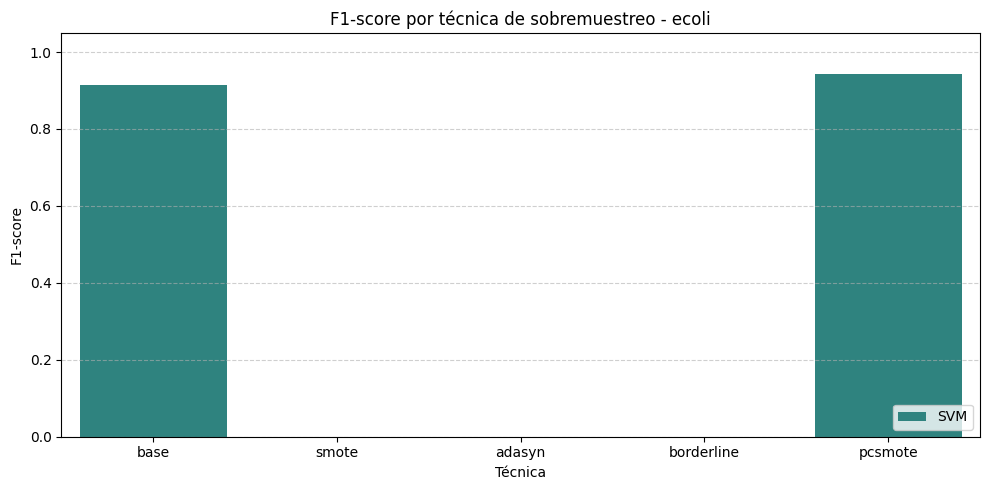

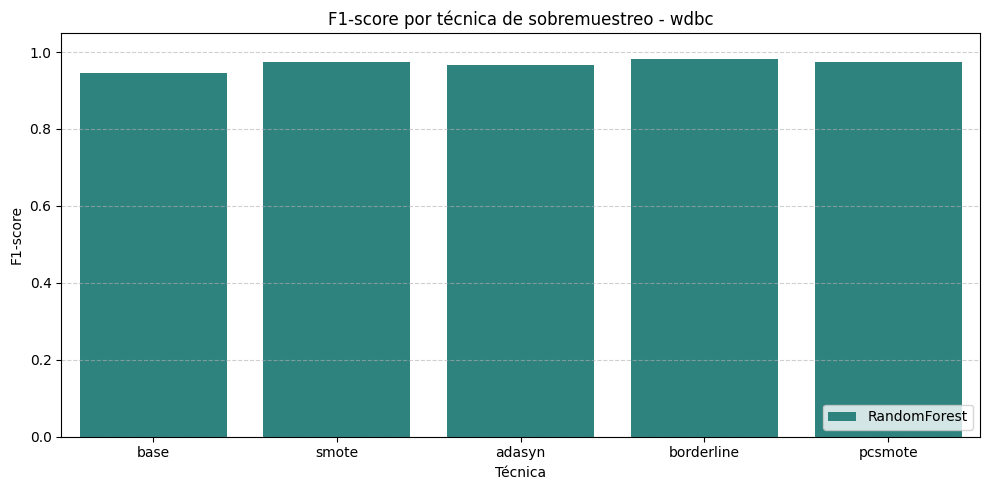

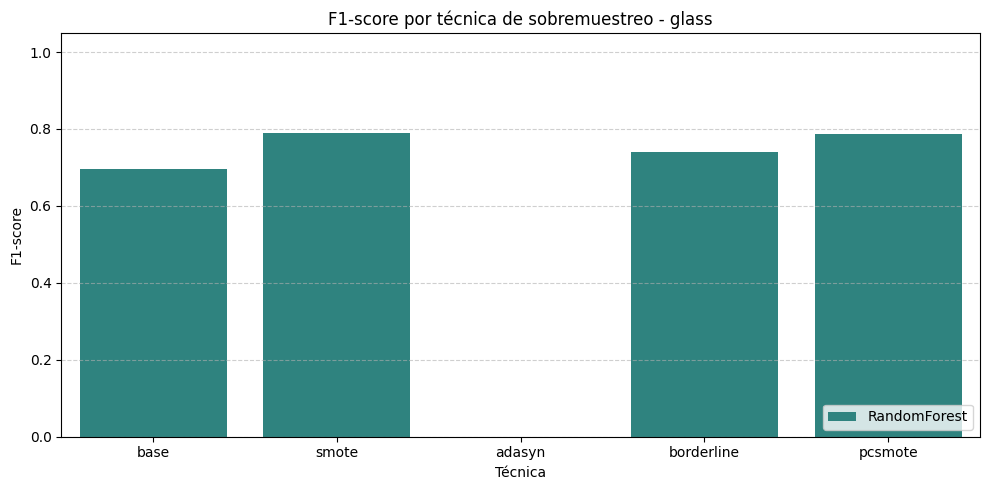

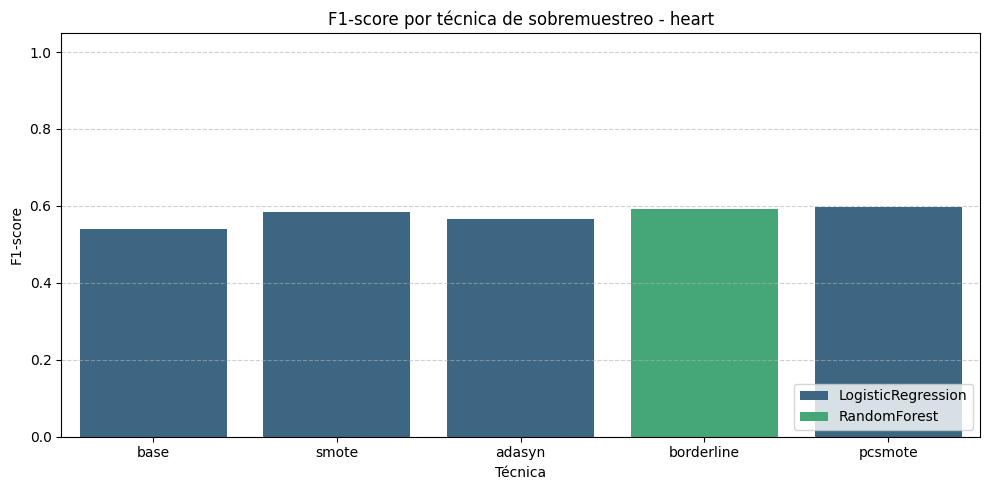

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el resumen
df = pd.read_csv("../resultados/resumen_mejores_por_tecnica.csv")

# Ajustar orden de técnicas para mejor visualización
orden_tecnicas = ['base', 'smote', 'adasyn', 'borderline', 'pcsmote']
df['tecnica'] = pd.Categorical(df['tecnica'], categories=orden_tecnicas, ordered=True)

# Plot por dataset
for dataset in df['dataset'].unique():
    plt.figure(figsize=(10, 5))
    df_sub = df[df['dataset'] == dataset].sort_values("tecnica")

    sns.barplot(
        data=df_sub,
        x="tecnica",
        y="f1_score",
        hue="modelo",  # opcional: para ver qué modelo dio ese resultado
        dodge=False,
        palette="viridis"
    )

    plt.title(f"F1-score por técnica de sobremuestreo - {dataset}")
    plt.ylabel("F1-score")
    plt.ylim(0, 1.05)
    plt.xlabel("Técnica")
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.legend(loc="lower right")
    plt.show()
